## TM test of first order and for complex media
In the TE polarization, we have demonstrated that quadrant sorting works. However, in the TM polarization, a naive quadrant sort seems to be ineffective, specifically when any of the $\epsilon <0$.

However, since we know what the correct answer should look like, it appears that the correct sorting procedure is simple.
1. Any real k MUST BE OF ONE SIGN ONLY (POSITIVE)
2. pure imaginaries must be of ONE SIGN ONLY (POSITIVE)
3. nonzero real and nonzero imaginary k must come in complex conjugate pairs (so in $k^2$ space, they correspond to two separate eigenvalues)


In [1]:
## same as the analytic case but with the fft
import numpy as np
import sys
sys.path.append('D:\\StanfordYearTwo\\RCWA\\')
import matplotlib.pyplot as plt
from numpy.linalg import cond
import cmath;
from scipy.fftpack import fft, fftfreq, fftshift, rfft
from scipy import linalg as LA
from numpy.linalg import solve as bslash
from RCWA_1D_functions.grating_fft.grating_conv import *


In [2]:
def nonHermitianEigenSorter(eigenvalues):
    N = len(eigenvalues);
    sorted_indices=[];
    sorted_eigs = [];
    for i in range(N):
        eig = eigenvalues[i];
        if(np.real(eig)>0 and np.imag(eig) == 0):
            sorted_indices.append(i); sorted_eigs.append(eig);
        elif(np.real(eig)==0 and np.imag(eig) > 0): 
            sorted_indices.append(i); sorted_eigs.append(eig);
        elif(np.real(eig)>0 and abs(np.imag(eig)) > 0): 
            sorted_indices.append(i); sorted_eigs.append(eig);
    return sorted_eigs, sorted_indices;

def eigenMatcher():
    return;

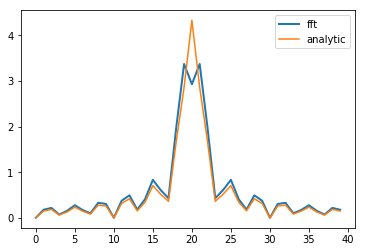

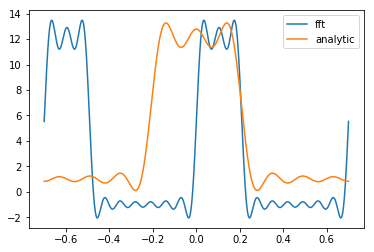

In [8]:
# Moharam et. al Formulation for stable and efficient implementation for RCWA
plt.close("all")
'''
1D TM implementation of PLANAR DIFFRACTiON
STILL NOT WORKING YET

only: sign convention is exp(-ikr) (is the positive propagating wave), so loss is +  not - 
source for fourier decomps is from the paper: Formulation for stable and efficient implementation of
the rigorous coupled-wave analysis of binary gratings by Moharam et. al
'''

L0 = 1e-6;
e0 = 8.854e-12;
mu0 = 4*np.pi*1e-8;
fill_factor = 0.3; # 50% of the unit cell is the ridge material


num_ord = 10; #INCREASING NUMBER OF ORDERS SEEMS TO CAUSE THIS THING TO FAIL, to many orders induce evanescence...particularly
               # when there is a small fill factor
PQ = 2*num_ord+1;
indices = np.arange(-num_ord, num_ord+1)

n_ridge = 3.48; #3.48;              # ridge
n_groove = 1;                # groove (unit-less)
lattice_constant = 0.7;  # SI units
# we need to be careful about what lattice constant means
# in the gaylord paper, lattice constant exactly means (0, L) is one unit cell


d = 0.46;               # thickness, SI units

Nx = 2*256;
eps_r = -n_groove**2*np.ones((2*Nx, 1)); #put in a lot of points in eps_r
border = int(2*Nx*fill_factor);
eps_r[0:border] = n_ridge**2;


fft_fourier_array = grating_fft(eps_r);
x = np.linspace(-lattice_constant,lattice_constant,2*Nx);
period = lattice_constant;
fft_reconstruct = fourier_reconstruction_general(x, period, num_ord, fft_fourier_array);

fourier_array_analytic = grating_fourier_array(Nx, fill_factor, n_ridge, -n_groove);
analytic_reconstruct = fourier_reconstruction(x, period, num_ord, n_ridge, -n_groove, fill_factor)


plt.figure();
plt.plot(np.abs(fft_fourier_array[Nx-20:Nx+20]), linewidth=2)
plt.plot(np.abs(fourier_array_analytic[Nx-20:Nx+20]));
plt.legend(('fft', 'analytic'))
plt.show()

plt.figure();
plt.plot(x,fft_reconstruct)
plt.plot(x,analytic_reconstruct);
plt.legend(['fft', 'analytic'])
plt.show()


In [9]:

##construct convolution matrix
E = np.zeros((2 * num_ord + 1, 2 * num_ord + 1)); E = E.astype('complex')
p0 = Nx; #int(Nx/2);
p_index = np.arange(-num_ord, num_ord + 1);
q_index = np.arange(-num_ord, num_ord + 1);
fourier_array = fft_fourier_array;#fourier_array_analytic;
detected_pffts = np.zeros_like(E);
for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    row_index = p_index[prow];
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        detected_pffts[prow, pcol] = pfft;
        E[prow, pcol] = fourier_array[p0 + pfft];  # fill conv matrix from top left to top right

## FFT of 1/e;
inv_fft_fourier_array = grating_fft(1/eps_r);
##construct convolution matrix
E_conv_inv = np.zeros((2 * num_ord + 1, 2 * num_ord + 1));
E_conv_inv = E_conv_inv.astype('complex')
p0 = Nx;
p_index = np.arange(-num_ord, num_ord + 1);
for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        E_conv_inv[prow, pcol] = inv_fft_fourier_array[p0 + pfft];  # fill conv matrix from top left to top right

print(E_conv_inv.shape);
print(E.shape)

(21, 21)
(21, 21)


## Observations to note
We can see that floating point precision can completely alter the sign when we take a square root of the beigenvals.

wavelength: 0.5
conditioning of AO: 807
[1, 3, 5, 8, 9, 12, 13, 16, 19, 20, 21, 24, 25, 34, 35, 36, 37, 38, 39, 40, 41]
21
[ 0.        -14.27968352j -0.        +14.27968352j
 -0.         -6.26262847j  0.         +6.26262847j
 -7.04273129 +0.j          7.04273129 +0.j
 -6.12914703 -0.26175774j -6.12914703 +0.26175774j
  6.12914703 -0.26175774j  6.12914703 +0.26175774j
 -5.80024207 +0.j         -5.43160805 -0.j
  5.80024207 +0.j          5.43160805 -0.j
 -4.72158748 +0.j          0.         -3.27070354j
 -0.         +3.27070354j -4.27663874 +0.j
 -0.         -2.49432288j  4.72158748 +0.j
  0.         +2.49432288j  4.27663874 -0.j
 -3.53777929 -0.11519421j -3.53777929 +0.11519421j
  3.53777929 -0.11519421j  3.53777929 +0.11519421j
 -3.2310896  +0.j         -2.82270981 +0.j
 -2.209526   -0.j         -1.85423242 +0.j
 -1.3463863  -0.5063975j  -1.3463863  +0.5063975j
 -1.12982512 +0.j         -1.14902712 +0.j
  3.2310896  -0.j          2.82270981 +0.j
  2.209526   -0.j          1.3463863  -0

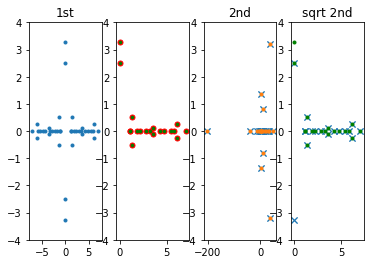

wavelength: 0.5620689655172414
conditioning of AO: 661
[1, 3, 4, 5, 6, 10, 11, 14, 16, 17, 18, 19, 25, 26, 28, 36, 37, 38, 39, 40, 41]
21
[-0.        -16.0782037j  -0.        +16.0782037j
  0.         -7.18562107j  0.         +7.18562107j
  7.89550793 +0.j          7.1090287  -0.37215548j
  7.1090287  +0.37215548j -7.89550793 -0.j
 -7.1090287  +0.37215548j -7.1090287  -0.37215548j
  6.49599476 -0.j          6.00807186 +0.j
 -6.49599476 +0.j         -6.00807186 -0.j
  5.27088545 +0.j          0.         -3.20855172j
  4.76237658 -0.j          4.19993695 -0.2240147j
  4.19993695 +0.2240147j   0.         +3.20855172j
 -5.27088545 +0.j         -4.76237658 +0.j
 -4.19993695 +0.2240147j  -4.19993695 -0.2240147j
  0.         -2.12521036j -0.         +2.12521036j
  3.57591111 -0.j         -3.57591111 -0.j
  3.07582105 -0.j         -3.07582105 -0.j
 -2.23881408 -0.24926682j -2.23881408 +0.24926682j
 -1.98756756 -0.j         -1.81141672 -0.j
 -1.10243526 -0.j         -1.06757428 +0.j
  2.2388140

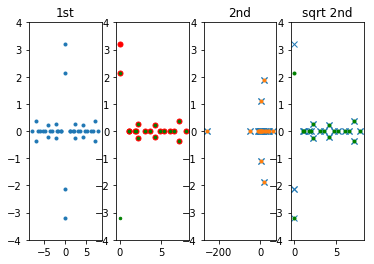

wavelength: 0.6241379310344828
conditioning of AO: 1817
[0, 2, 7, 8, 9, 12, 14, 18, 20, 25, 27, 28, 29, 30, 31, 32, 33, 35, 36, 40, 41]
21
[-0.        +17.87394403j -0.        -17.87394403j
  0.         +8.09281449j  0.         -8.09281449j
 -8.75019808 -0.j         -8.0440548  +0.37981621j
 -8.0440548  -0.37981621j  8.75019808 +0.j
  8.0440548  +0.37981621j  8.0440548  -0.37981621j
 -7.19357945 +0.j         -6.62556589 -0.j
  7.19357945 -0.j         -5.81656818 +0.j
  6.62556589 -0.j         -5.25477484 -0.j
 -4.8183857  +0.06439663j -4.8183857  -0.06439663j
  0.         +3.13719346j  0.         -3.13719346j
  5.81656818 +0.j         -3.91758001 +0.j
 -3.35963222 +0.j         -2.8417689  +0.31767344j
 -2.8417689  -0.31767344j  0.         +1.5727683j
 -0.         -1.5727683j   5.25477484 +0.j
  4.8183857  -0.06439663j  4.8183857  +0.06439663j
  3.91758001 -0.j          3.35963222 +0.j
  2.8417689  +0.31767344j  2.8417689  -0.31767344j
 -2.12803559 +0.j          2.12803559 -0.j
  1.7195

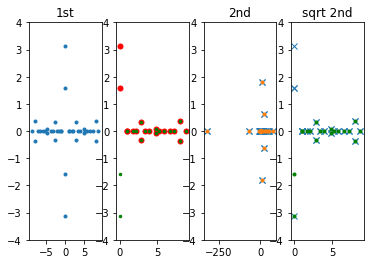

wavelength: 0.6862068965517241
conditioning of AO: 6195
[0, 2, 4, 5, 6, 10, 12, 14, 16, 17, 18, 22, 24, 25, 26, 27, 29, 33, 34, 35, 37]
21
[ 0.        +19.66774754j  0.        -19.66774754j
 -0.         +8.98908845j -0.         -8.98908845j
  9.6062857  -0.j          8.95852874 +0.33759763j
  8.95852874 -0.33759763j -9.6062857  +0.j
 -8.95852874 +0.33759763j -8.95852874 -0.33759763j
  7.892489   +0.j         -7.892489   -0.j
  7.25400577 -0.j         -7.25400577 -0.j
  6.35310964 -0.j         -6.35310964 +0.j
  5.72964124 -0.j          5.7506102  -0.j
  5.11171867 -0.j         -5.72964124 +0.j
 -5.7506102  +0.j         -5.11171867 -0.j
  0.         +3.05566371j -0.         -3.05566371j
  4.24361606 +0.j          3.65164815 -0.j
  3.44494433 -0.j          3.21856136 +0.j
 -4.24361606 +0.j          2.26637127 -0.j
 -3.65164815 -0.j         -3.44494433 -0.j
 -3.21856136 +0.j          1.77606714 +0.j
  0.81475631 +0.56624442j  0.81475631 -0.56624442j
 -2.26637127 +0.j          1.02136139 +

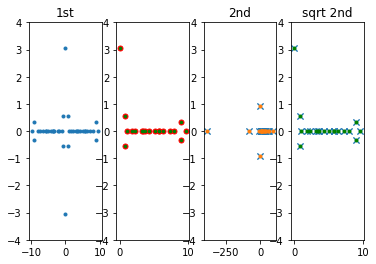

wavelength: 0.7482758620689655
conditioning of AO: 1422
[0, 2, 7, 8, 9, 12, 13, 17, 18, 19, 21, 22, 32, 33, 34, 35, 37, 38, 39, 40, 41]
21
[ -0.        +21.46014223j  -0.        -21.46014223j
   0.         +9.87744503j   0.         -9.87744503j
 -10.46342862 +0.j          -9.86030712 +0.2423741j
  -9.86030712 -0.2423741j   10.46342862 -0.j
   9.86030712 +0.2423741j    9.86030712 -0.2423741j
  -8.59239477 -0.j          -7.88744909 -0.j
   8.59239477 +0.j           7.88744909 +0.j
  -6.86364828 +0.j          -6.52218819 -0.j
  -6.2485352  +0.j           6.86364828 -0.j
   6.52218819 +0.j           6.2485352  -0.j
  -5.52487438 -0.j           5.52487438 +0.j
  -0.         +2.96276029j  -0.         -2.96276029j
  -3.94754482 +0.j          -4.45716807 -0.j
  -4.36075889 +0.j          -3.32670952 +0.j
  -2.39072657 -0.j          -1.39240353 +0.62162225j
  -1.39240353 -0.62162225j  -1.85426355 -0.j
   3.94754482 -0.j           4.45716807 +0.j
   4.36075889 -0.j           3.32670952 +0.j
  -1.

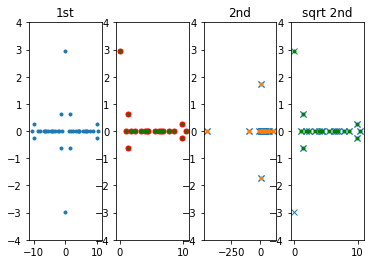

wavelength: 0.8103448275862069
conditioning of AO: 889
[1, 3, 7, 8, 9, 11, 13, 16, 17, 19, 21, 26, 27, 28, 30, 36, 37, 38, 39, 40, 41]
21
[  0.        -23.25147745j  -0.        +23.25147745j
   0.        -10.75985538j  -0.        +10.75985538j
 -11.32138969 +0.j         -10.8784281  -0.j
 -10.62829888 +0.j          11.32138969 +0.j
  10.8784281  -0.j          10.62829888 +0.j
  -9.29307443 -0.j           9.29307443 +0.j
  -8.52375724 -0.j           8.52375724 +0.j
  -7.3292888  -0.13591313j  -7.3292888  +0.13591313j
   7.3292888  -0.13591313j   7.3292888  +0.13591313j
  -6.74785053 +0.j           6.74785053 +0.j
  -5.9517305  +0.j           5.9517305  -0.j
  -4.90470421 -0.25849156j  -4.90470421 +0.25849156j
   0.         -2.85691275j  -4.24564372 +0.j
   0.         +2.85691275j   4.90470421 -0.25849156j
   4.90470421 +0.25849156j  -3.5362527  -0.j
   4.24564372 +0.j          -2.45745929 +0.j
  -1.79046824 -0.42480785j  -1.79046824 +0.42480785j
  -1.94115961 -0.j          -0.98286038 -

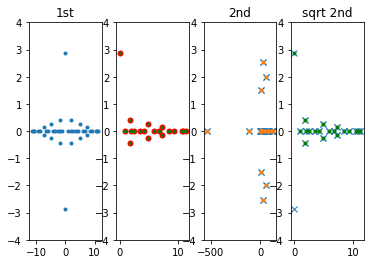

wavelength: 0.8724137931034482
conditioning of AO: 989
[0, 2, 7, 8, 9, 12, 15, 16, 17, 19, 24, 25, 27, 28, 29, 36, 37, 38, 39, 40, 41]
21
[  0.        +25.04199446j   0.        -25.04199446j
   0.        +11.6376757j    0.        -11.6376757j
 -12.17999879 +0.j         -11.96536106 -0.j
 -11.31476563 +0.j          12.17999879 +0.j
  11.96536106 +0.j          11.31476563 -0.j
  -9.99437171 -0.j          -9.16192477 -0.j
   9.99437171 +0.j          -7.95698373 +0.23341413j
  -7.95698373 -0.23341413j   9.16192477 +0.j
   7.95698373 +0.23341413j   7.95698373 -0.23341413j
  -7.24814671 +0.j           7.24814671 -0.j
  -6.38407606 +0.j          -5.38054269 +0.32282434j
  -5.38054269 -0.32282434j  -4.54506515 +0.j
   6.38407606 -0.j          -0.         +2.73598198j
  -0.         -2.73598198j   5.38054269 +0.32282434j
   5.38054269 -0.32282434j   4.54506515 -0.j
  -3.76270319 -0.j          -2.55824922 -0.34967451j
  -2.55824922 +0.34967451j  -1.66939222 +0.j
  -2.03265751 +0.j          -0.958

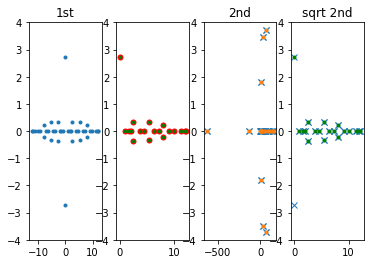

wavelength: 0.9344827586206896
conditioning of AO: 1350
[0, 2, 7, 8, 9, 11, 15, 16, 17, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33, 34, 35]
21
[ -0.        +26.8318656j   -0.        -26.8318656j
   0.        +12.51187334j  -0.        -12.51187334j
 -13.03913034 -0.j         -12.97985482 -0.j
 -12.06403435 +0.j          13.03913034 +0.j
  12.97985482 +0.j          12.06403435 -0.j
 -10.69617306 +0.j          10.69617306 -0.j
  -9.8013978  +0.j          -8.57876981 +0.28792608j
  -8.57876981 -0.28792608j   9.8013978  -0.j
   8.57876981 +0.28792608j   8.57876981 -0.28792608j
  -7.7491655  +0.j           7.7491655  -0.j
  -6.81940767 -0.j          -5.84496875 +0.34954539j
  -5.84496875 -0.34954539j   6.81940767 +0.j
   5.84496875 +0.34954539j   5.84496875 -0.34954539j
  -4.84526631 +0.j           4.84526631 +0.j
  -0.         +2.59690907j  -0.         -2.59690907j
   3.99631777 +0.j           2.93864944 +0.437997j
   2.93864944 -0.437997j     1.59979379 -0.j
   2.12683731 +0.j           0.9273

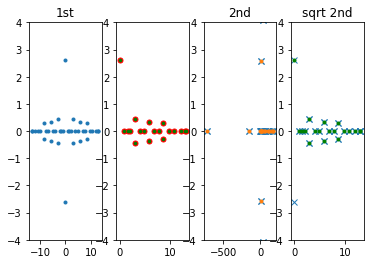

wavelength: 0.9965517241379309
conditioning of AO: 1926
[1, 3, 4, 5, 9, 11, 15, 16, 17, 19, 23, 24, 25, 27, 32, 33, 34, 35, 39, 40, 41]
21
[  0.        -28.62121754j   0.        +28.62121754j
   0.        -13.38315857j  -0.        +13.38315857j
  13.97089611 +0.j          13.89868948 -0.j
 -13.97089611 -0.j         -13.89868948 -0.j
 -12.82923545 +0.j          12.82923545 -0.j
 -11.3983934  +0.j          11.3983934  +0.j
 -10.44183761 +0.j          -9.19621065 +0.32561929j
  -9.19621065 -0.32561929j  10.44183761 -0.j
   9.19621065 -0.32561929j   9.19621065 +0.32561929j
  -8.2507357  -0.j           8.2507357  -0.j
  -7.25663679 -0.j          -6.30173273 -0.35574588j
  -6.30173273 +0.35574588j   7.25663679 +0.j
   6.30173273 +0.35574588j   6.30173273 -0.35574588j
  -5.14587729 -0.j           5.14587729 +0.j
   0.         -2.43502533j  -4.23393193 +0.j
  -3.27095472 -0.4470523j   -3.27095472 +0.4470523j
  -0.         +2.43502533j   4.23393193 -0.j
   3.27095472 +0.4470523j    3.27095472 -

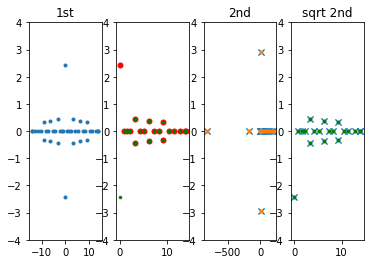

wavelength: 1.0586206896551724
conditioning of AO: 2981
[0, 2, 4, 5, 9, 11, 15, 17, 18, 22, 24, 25, 26, 30, 31, 33, 34, 35, 39, 40, 41]
21
[ -0.        +30.41014554j   0.        -30.41014554j
   0.        +14.25206554j  -0.        -14.25206554j
  14.94851384 +0.j          14.75860313 -0.j
 -14.94851384 -0.j         -14.75860313 -0.j
 -13.60185827 -0.j          13.60185827 -0.j
 -12.10096735 -0.j          12.10096735 +0.j
 -11.08302123 +0.j          -9.81031004 -0.35399726j
  -9.81031004 +0.35399726j  11.08302123 -0.j
  -8.75273959 +0.j           9.81031004 +0.35399726j
   9.81031004 -0.35399726j  -7.69518962 -0.j
  -6.75294447 +0.34738352j  -6.75294447 -0.34738352j
   8.75273959 -0.j          -5.44662842 +0.j
   7.69518962 -0.j           6.75294447 +0.34738352j
   6.75294447 -0.34738352j  -4.47412846 +0.j
  -3.58245323 +0.41630755j  -3.58245323 -0.41630755j
   5.44662842 +0.j          -0.         +2.24249003j
  -0.         -2.24249003j   4.47412846 -0.j
   3.58245323 +0.41630755j   3.5

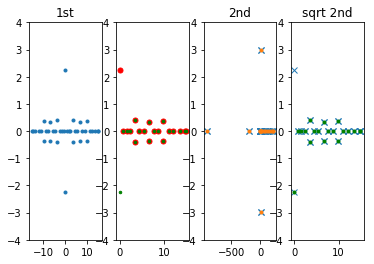

wavelength: 1.1206896551724137
conditioning of AO: 5510
[0, 2, 6, 7, 9, 11, 15, 16, 17, 19, 23, 24, 25, 27, 31, 32, 33, 34, 39, 40, 41]
21
[ -0.        +32.19872274j  -0.        -32.19872274j
  -0.        +15.1190042j   -0.        -15.1190042j
 -15.91701305 +0.j         -15.61881399 +0.j
  15.91701305 -0.j          15.61881399 -0.j
 -14.37872131 -0.j          14.37872131 +0.j
 -12.80384349 -0.j          12.80384349 +0.j
 -11.72479376 -0.j         -10.42176086 +0.37647697j
 -10.42176086 -0.37647697j  11.72479376 -0.j
  10.42176086 +0.37647697j  10.42176086 -0.37647697j
  -9.25509389 +0.j           9.25509389 +0.j
  -8.13472407 +0.j          -7.1999397  +0.32656353j
  -7.1999397  -0.32656353j   8.13472407 -0.j
   7.1999397  +0.32656353j   7.1999397  -0.32656353j
  -5.7473127  -0.j           5.7473127  +0.j
  -4.716147   +0.j          -3.88165352 -0.34989433j
  -3.88165352 +0.34989433j   4.716147   -0.j
   3.88165352 +0.34989433j   3.88165352 -0.34989433j
   0.         +2.00391125j  -0.  

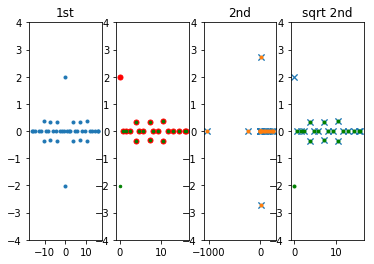

wavelength: 1.182758620689655
conditioning of AO: 19525
[0, 2, 6, 7, 9, 11, 15, 16, 17, 22, 23, 24, 25, 27, 31, 32, 33, 34, 36, 37, 40]
21
[  0.        +33.98700625j   0.        -33.98700625j
  -0.        +15.98429467j  -0.        -15.98429467j
 -16.87877459 -0.j         -16.47927654 -0.j
  16.87877459 +0.j          16.47927654 -0.j
 -15.1582963  +0.j          15.1582963  -0.j
 -13.50698057 -0.j          13.50698057 +0.j
 -12.36704304 +0.j         -11.03106464 +0.39493408j
 -11.03106464 -0.39493408j  12.36704304 -0.j
  11.03106464 -0.39493408j  11.03106464 +0.39493408j
  -9.75773818 -0.j          -8.57501807 +0.j
  -7.64362652 +0.2930262j   -7.64362652 -0.2930262j
   9.75773818 +0.j           8.57501807 -0.j
   7.64362652 -0.2930262j    7.64362652 +0.2930262j
  -6.04776408 +0.j           6.04776408 -0.j
  -4.95952879 -0.j          -4.17265213 +0.22903763j
  -4.17265213 -0.22903763j   4.95952879 +0.j
   4.17265213 +0.22903763j   4.17265213 -0.22903763j
  -0.         +1.67811525j   0.   

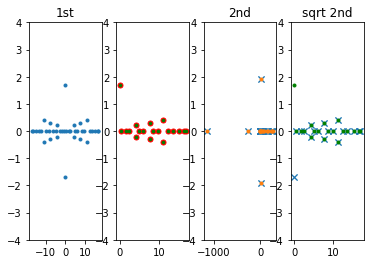

wavelength: 1.2448275862068965
conditioning of AO: 16657
[1, 3, 4, 5, 8, 10, 12, 13, 14, 16, 19, 20, 21, 26, 28, 29, 30, 34, 35, 36, 38]
21
[  0.        -35.77504133j   0.        +35.77504133j
  -0.        -16.84819077j  -0.        +16.84819077j
  17.83530425 +0.j          17.33995409 -0.j
 -17.83530425 -0.j         -17.33995409 +0.j
  15.93973791 -0.j         -15.93973791 -0.j
  14.210345   +0.j         -14.210345   -0.j
  13.00968521 -0.j          11.63859709 -0.41051313j
  11.63859709 +0.41051313j -13.00968521 +0.j
  10.26062768 -0.j         -11.63859709 +0.41051313j
 -11.63859709 -0.41051313j   9.01591833 +0.j
   8.08465287 -0.24355033j   8.08465287 +0.24355033j
 -10.26062768 -0.j          -9.01591833 -0.j
  -8.08465287 +0.24355033j  -8.08465287 -0.24355033j
   6.34784361 -0.j          -6.34784361 -0.j
   5.20397342 +0.j           4.64091084 +0.j
   4.27472324 -0.j          -5.20397342 +0.j
  -4.64091084 +0.j          -4.27472324 +0.j
   2.60543145 +0.j           1.6935583  -0.j
  

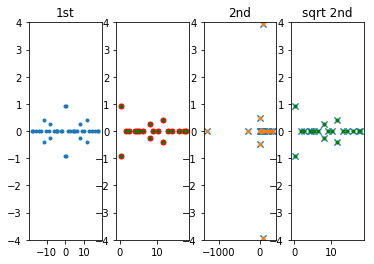

wavelength: 1.306896551724138
conditioning of AO: 6418
[1, 3, 4, 5, 8, 10, 12, 13, 14, 19, 23, 24, 25, 27, 31, 32, 33, 38, 39, 40, 41]
21
[  0.        -37.56286434j   0.        +37.56286434j
  -0.        -17.71089642j   0.        +17.71089642j
  18.78763586 -0.j          18.20081676 -0.j
 -18.78763586 +0.j         -18.20081676 -0.j
  16.722533   +0.j         -16.722533   +0.j
  14.91390896 +0.j         -14.91390896 -0.j
  13.65265596 -0.j          12.24464708 -0.4239626j
  12.24464708 +0.4239626j  -13.65265596 -0.j
 -12.24464708 -0.4239626j  -12.24464708 +0.4239626j
 -10.76372847 -0.j          10.76372847 +0.j
  -9.45731402 +0.j          -8.5234979  -0.16645638j
  -8.5234979  +0.16645638j   9.45731402 -0.j
   8.5234979  +0.16645638j   8.5234979  -0.16645638j
  -6.64743003 +0.j           6.64743003 +0.j
  -5.44927213 -0.j          -5.10419416 -0.j
  -4.37314127 +0.j           5.44927213 -0.j
   5.10419416 -0.j           4.37314127 +0.j
  -2.6976317  +0.j          -1.72992865 +0.j
  -0.8

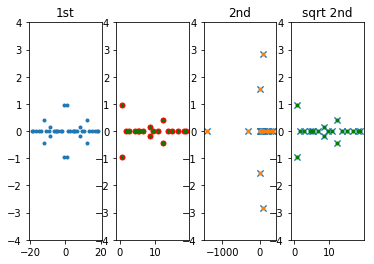

wavelength: 1.3689655172413793
conditioning of AO: 4187
[0, 2, 4, 5, 8, 10, 12, 13, 14, 18, 20, 21, 22, 26, 27, 28, 29, 34, 35, 36, 37]
21
[ -0.        +39.35050486j  -0.        -39.35050486j
   0.        +18.57257742j   0.        -18.57257742j
  19.73651909 +0.j          19.06183995 -0.j
 -19.73651909 -0.j         -19.06183995 +0.j
  17.50634858 +0.j         -17.50634858 +0.j
  15.61764918 +0.j         -15.61764918 +0.j
  14.29590488 +0.j          12.84944139 +0.43579663j
  12.84944139 -0.43579663j -14.29590488 -0.j
 -12.84944139 -0.43579663j -12.84944139 +0.43579663j
  11.26701435 +0.j         -11.26701435 -0.j
   9.89912207 +0.j           9.05238953 -0.j
   8.86866228 +0.j          -9.89912207 +0.j
  -9.05238953 +0.j          -8.86866228 -0.j
   6.94641269 -0.j           5.51281212 -0.j
   5.69527319 +0.j           4.51968698 -0.j
  -6.94641269 +0.j          -5.51281212 +0.j
  -5.69527319 -0.j          -4.51968698 -0.j
   2.7866378  -0.j           1.76854858 -0.j
   1.0851861  +0.94

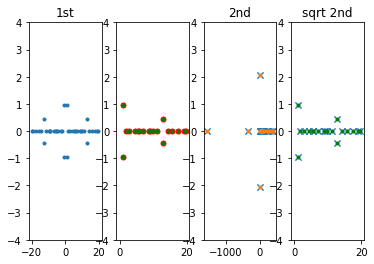

wavelength: 1.4310344827586206
conditioning of AO: 3212
[0, 2, 6, 7, 9, 11, 15, 16, 17, 18, 20, 21, 22, 26, 28, 29, 30, 34, 35, 36, 37]
21
[ -0.        +41.13798715j  -0.        -41.13798715j
   0.        +19.43336998j   0.        -19.43336998j
 -20.68251906 -0.j         -19.92300326 -0.j
  20.68251906 +0.j          19.92300326 -0.j
 -18.29095731 +0.j          18.29095731 +0.j
 -16.321546   -0.j          16.321546   -0.j
 -14.93939177 -0.j         -13.45316122 +0.44638175j
 -13.45316122 -0.44638175j  14.93939177 +0.j
  13.45316122 -0.44638175j  13.45316122 +0.44638175j
  11.77046467 -0.j         -11.77046467 -0.j
  10.34127849 -0.j           9.61676002 -0.j
   9.17528018 +0.j         -10.34127849 +0.j
  -9.61676002 +0.j          -9.17528018 -0.j
   7.24468587 -0.j          -7.24468587 -0.j
   5.9009325  +0.j           5.9418624  +0.j
   4.68170768 -0.j          -5.9009325  -0.j
  -5.9418624  -0.j          -4.68170768 +0.j
   2.87102045 -0.j           1.80898392 +0.j
   1.30056611 -0.89

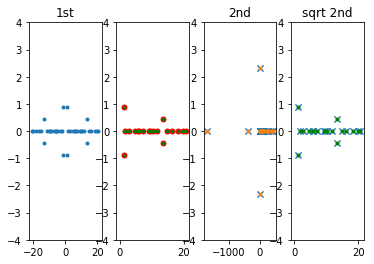

wavelength: 1.4931034482758618
conditioning of AO: 2667
[0, 2, 4, 5, 8, 10, 12, 13, 14, 18, 19, 20, 21, 26, 27, 28, 29, 34, 35, 36, 37]
21
[ -0.        +42.92533136j  -0.        -42.92533136j
   0.        +20.29338709j   0.        -20.29338709j
  21.6260743  +0.j          20.78428956 +0.j
 -21.6260743  +0.j         -20.78428956 +0.j
  19.07619769 +0.j         -19.07619769 +0.j
  17.02558263 +0.j         -17.02558263 +0.j
  15.58308408 -0.j          14.05595338 +0.45598694j
  14.05595338 -0.45598694j -15.58308408 -0.j
 -14.05595338 -0.45598694j -14.05595338 +0.45598694j
  12.27406282 +0.j          10.7837328  +0.j
  10.13491297 -0.j           9.52549667 -0.j
 -12.27406282 -0.j         -10.7837328  -0.j
 -10.13491297 -0.j          -9.52549667 +0.j
   7.54214379 +0.j           6.27738634 -0.j
   6.18895144 +0.j           4.85151792 +0.j
  -7.54214379 +0.j          -6.27738634 +0.j
  -6.18895144 +0.j          -4.85151792 +0.j
   2.94858211 +0.j           1.4885511  +0.81224943j
   1.850929

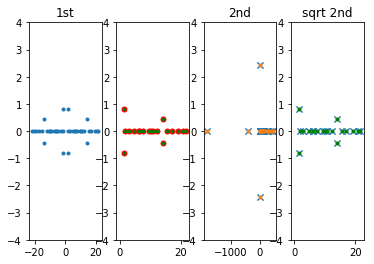

wavelength: 1.5551724137931033
conditioning of AO: 2320
[0, 2, 6, 7, 9, 11, 15, 16, 17, 22, 23, 24, 25, 27, 31, 32, 33, 38, 39, 40, 41]
21
[  0.        +44.71255434j  -0.        -44.71255434j
  -0.        +21.15272328j  -0.        -21.15272328j
 -22.5675328  -0.j         -21.64568442 -0.j
  22.5675328  +0.j          21.64568442 -0.j
 -19.86195123 +0.j          19.86195123 +0.j
 -17.72974463 -0.j          17.72974463 -0.j
 -16.22695514 +0.j         -14.65793838 +0.46481424j
 -14.65793838 -0.46481424j  16.22695514 +0.j
  14.65793838 -0.46481424j  14.65793838 +0.46481424j
 -12.77779521 +0.j         -11.22644447 -0.j
 -10.63817497 +0.j          -9.8883462  -0.j
  12.77779521 +0.j          11.22644447 -0.j
  10.63817497 -0.j           9.8883462  -0.j
  -7.83867562 +0.j           7.83867562 +0.j
  -6.64618322 +0.j          -6.43647042 +0.j
  -5.02600802 +0.j           6.64618322 +0.j
   6.43647042 -0.j           5.02600802 -0.j
  -3.01549401 -0.j          -1.66338835 +0.69851633j
  -1.894161

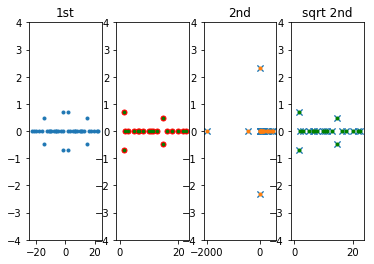

wavelength: 1.6172413793103446
conditioning of AO: 2080
[1, 3, 4, 5, 8, 10, 12, 13, 14, 18, 19, 20, 21, 26, 27, 28, 29, 34, 35, 36, 37]
21
[ -0.        -46.49967028j  -0.        +46.49967028j
  -0.        -22.01145825j   0.        +22.01145825j
  23.50717569 +0.j          22.50717559 +0.j
 -23.50717569 -0.j         -22.50717559 +0.j
  20.64812866 +0.j         -20.64812866 -0.j
  18.43401952 +0.j         -18.43401952 -0.j
  16.87098281 +0.j          15.2592162  -0.47301841j
  15.2592162  +0.47301841j -16.87098281 -0.j
 -15.2592162  -0.47301841j -15.2592162  +0.47301841j
  13.28165048 -0.j          11.66938043 -0.j
  11.13314208 -0.j          10.25752725 +0.j
 -13.28165048 -0.j         -11.66938043 -0.j
 -11.13314208 +0.j         -10.25752725 +0.j
   8.13416007 +0.j           7.00962461 +0.j
   6.68436301 +0.j           5.20361046 -0.j
  -8.13416007 +0.j          -7.00962461 -0.j
  -6.68436301 -0.j          -5.20361046 +0.j
   3.06370962 -0.j           1.83519076 -0.52455246j
   1.938508

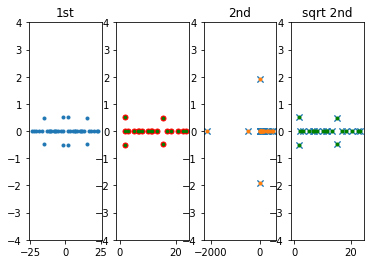

wavelength: 1.6793103448275861
conditioning of AO: 1904
[1, 2, 4, 5, 7, 10, 11, 12, 13, 18, 19, 20, 21, 26, 27, 28, 29, 34, 35, 36, 37]
21
[  0.        -48.28669125j   0.        +48.28669125j
  -0.        +22.8696597j    0.        -22.8696597j
  24.4452335  +0.j          23.36875257 -0.j
 -24.4452335  -0.j          21.43466121 -0.j
 -23.36875257 +0.j         -21.43466121 -0.j
  19.13839641 -0.j          17.51514856 +0.j
  15.85987061 +0.48071989j  15.85987061 -0.48071989j
 -19.13839641 +0.j         -17.51514856 +0.j
 -15.85987061 +0.48071989j -15.85987061 -0.48071989j
  13.78561903 -0.j          12.11251333 +0.j
  11.62256849 -0.j          10.63052875 -0.j
 -13.78561903 +0.j         -12.11251333 +0.j
 -11.62256849 +0.j         -10.63052875 +0.j
   8.42845885 +0.j           7.3692318  +0.j
   6.93258313 -0.j           5.38342701 +0.j
  -8.42845885 -0.j          -7.3692318  +0.j
  -6.93258313 +0.j          -5.38342701 -0.j
   3.06874194 -0.j           2.01968748 -0.05899406j
   2.0196874

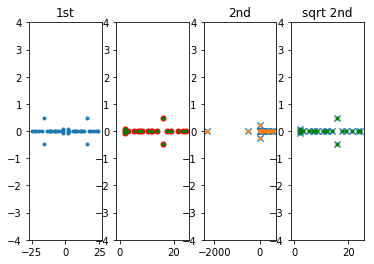

wavelength: 1.7413793103448274
conditioning of AO: 1895
[0, 3, 4, 5, 8, 10, 12, 13, 14, 18, 19, 20, 21, 26, 27, 28, 29, 34, 35, 36, 37]
21
[ -0.        +50.07362756j  -0.        -50.07362756j
   0.        -23.72738548j   0.        +23.72738548j
  25.38189759 +0.j          24.23040635 -0.j
 -25.38189759 -0.j         -24.23040635 -0.j
  22.22149486 +0.j         -22.22149486 +0.j
  19.84286577 +0.j         -19.84286577 -0.j
  18.15943675 +0.j          16.45997234 -0.48801373j
  16.45997234 +0.48801373j -18.15943675 -0.j
 -16.45997234 -0.48801373j -16.45997234 +0.48801373j
  14.28969255 -0.j          12.5558203  -0.j
  12.10792627 +0.j          11.00608151 -0.j
 -14.28969255 +0.j         -12.5558203  -0.j
 -12.10792627 -0.j         -11.00608151 +0.j
   8.72140812 -0.j           7.72611947 -0.j
   7.18109253 -0.j           5.56489664 -0.j
  -8.72140812 +0.j          -7.72611947 -0.j
  -7.18109253 +0.j          -5.56489664 -0.j
   2.92494561 +0.21251897j   2.92494561 -0.21251897j
   2.030028

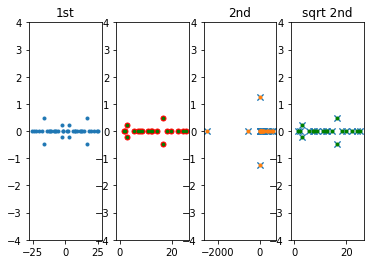

wavelength: 1.803448275862069
conditioning of AO: 2033
[0, 2, 4, 5, 8, 10, 12, 13, 14, 18, 19, 20, 21, 26, 27, 28, 29, 34, 35, 36, 37]
21
[  0.        +51.86048806j   0.        -51.86048806j
   0.        +24.58468535j  -0.        -24.58468535j
  26.31732853 +0.j          25.09212911 -0.j
 -26.31732853 -0.j         -25.09212911 -0.j
  23.0085865  +0.j         -23.0085865  -0.j
  20.54741924 +0.j         -20.54741924 -0.j
  18.80383404 +0.j          17.05958165 +0.49497584j
  17.05958165 -0.49497584j -18.80383404 +0.j
 -17.05958165 +0.49497584j -17.05958165 -0.49497584j
  14.79386381 +0.j          12.99928203 -0.j
  12.59011858 -0.j          11.38345318 -0.j
 -14.79386381 -0.j         -12.99928203 +0.j
 -12.59011858 +0.j         -11.38345318 -0.j
   9.0128064  -0.j           8.08117998 +0.j
   7.42985913 +0.j           5.74764624 +0.j
  -9.0128064  -0.j          -8.08117998 +0.j
  -7.42985913 +0.j          -5.74764624 +0.j
   3.14964837 +0.42460353j   3.14964837 -0.42460353j
   2.0770008

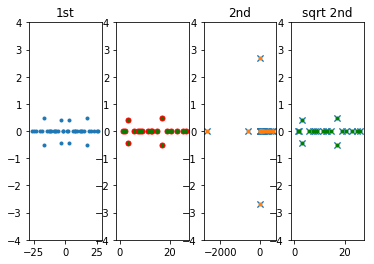

wavelength: 1.8655172413793102
conditioning of AO: 2175
[1, 3, 4, 5, 8, 10, 12, 13, 14, 18, 20, 21, 22, 26, 27, 28, 29, 34, 35, 36, 37]
21
[  0.        -53.64728042j   0.        +53.64728042j
   0.        -25.44160235j   0.        +25.44160235j
  27.25166226 -0.j          25.95391409 -0.j
 -27.25166226 -0.j         -25.95391409 +0.j
  23.79590121 -0.j         -23.79590121 -0.j
  21.25204942 -0.j         -21.25204942 +0.j
  19.44832901 +0.j          17.65875018 +0.50166743j
  17.65875018 -0.50166743j -19.44832901 +0.j
 -17.65875018 +0.50166743j -17.65875018 -0.50166743j
  15.29812641 -0.j         -15.29812641 +0.j
  13.44288207 -0.j          13.0697512  +0.j
  11.76218308 -0.j         -13.44288207 +0.j
 -13.0697512  +0.j         -11.76218308 -0.j
   9.30239637 -0.j           8.4351932  +0.j
   7.67885572 +0.j           5.93141549 -0.j
  -9.30239637 +0.j          -8.4351932  -0.j
  -7.67885572 +0.j          -5.93141549 +0.j
   3.34943783 -0.52970384j   3.34943783 +0.52970384j
   2.124675

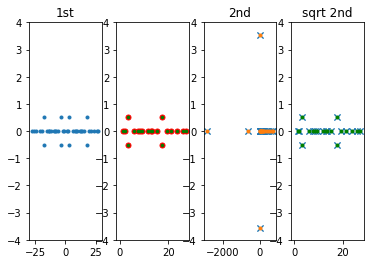

wavelength: 1.9275862068965515
conditioning of AO: 2323
[1, 3, 4, 5, 8, 10, 12, 13, 14, 18, 20, 21, 22, 26, 27, 28, 29, 34, 35, 36, 37]
21
[ -0.        -55.4340113j   -0.        +55.4340113j
  -0.        -26.29817389j   0.        +26.29817389j
  28.18501486 -0.j          26.81575536 +0.j
 -28.18501486 -0.j         -26.81575536 -0.j
  24.58341038 +0.j         -24.58341038 +0.j
  21.95674973 +0.j         -21.95674973 -0.j
  20.0929118  +0.j          18.25752248 -0.50813836j
  18.25752248 +0.50813836j -20.0929118  -0.j
 -18.25752248 +0.50813836j -18.25752248 -0.50813836j
  15.8024746  +0.j         -15.8024746  -0.j
  13.88660631 -0.j          13.54725649 -0.j
  12.14196299 -0.j         -13.88660631 -0.j
 -13.54725649 -0.j         -12.14196299 +0.j
   9.5898357  +0.j           8.78890878 -0.j
   7.92805906 -0.j           6.11601567 +0.j
  -9.5898357  -0.j          -8.78890878 +0.j
  -7.92805906 +0.j          -6.11601567 +0.j
   3.53647212 -0.60181379j   3.53647212 +0.60181379j
   2.1729870

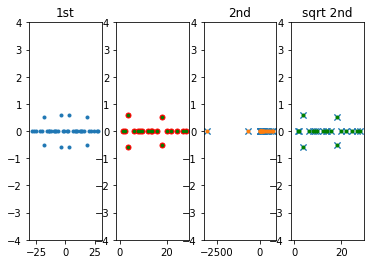

wavelength: 1.989655172413793
conditioning of AO: 2475
[1, 3, 4, 5, 8, 10, 12, 13, 14, 18, 20, 21, 22, 26, 27, 28, 29, 34, 35, 38, 40]
21
[  0.        -57.22068652j  -0.        +57.22068652j
  -0.        -27.15443264j  -0.        +27.15443264j
  29.11748612 +0.j          27.67764772 +0.j
 -29.11748612 -0.j         -27.67764772 -0.j
  25.37109027 -0.j         -25.37109027 +0.j
  22.66151435 -0.j         -22.66151435 +0.j
  20.73757387 -0.j          18.85593722 +0.51442948j
  18.85593722 -0.51442948j -20.73757387 +0.j
 -18.85593722 +0.51442948j -18.85593722 -0.51442948j
  16.30690324 -0.j         -16.30690324 -0.j
  14.33044252 -0.j          14.02295745 -0.j
  12.52257692 +0.j         -14.33044252 -0.j
 -14.02295745 -0.j         -12.52257692 +0.j
   9.87464671 -0.j           9.14312949 +0.j
   8.17744911 -0.j           6.3013057  +0.j
  -9.87464671 -0.j          -9.14312949 +0.j
  -8.17744911 -0.j          -6.3013057  +0.j
   3.71539054 -0.65701078j   3.71539054 +0.65701078j
  -3.7153905

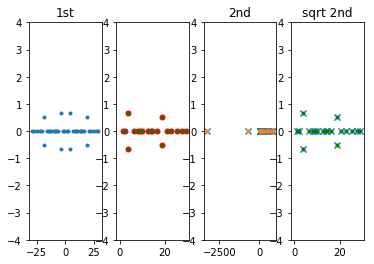

wavelength: 2.0517241379310343
conditioning of AO: 2632
[1, 3, 6, 7, 9, 11, 15, 16, 17, 19, 23, 24, 25, 30, 31, 32, 33, 36, 37, 39, 41]
21
[ -0.        -59.00731118j  -0.        +59.00731118j
  -0.        -28.01040729j  -0.        +28.01040729j
 -30.0491624  +0.j         -28.5395866  +0.j
  30.0491624  +0.j          28.5395866  -0.j
 -26.15892101 -0.j          26.15892101 -0.j
 -23.36633805 +0.j          23.36633805 -0.j
 -21.38230774 -0.j         -19.45402811 -0.52057458j
 -19.45402811 +0.52057458j  21.38230774 +0.j
  19.45402811 -0.52057458j  19.45402811 +0.52057458j
 -16.81140762 +0.j          16.81140762 -0.j
 -14.77438012 +0.j         -14.49710385 +0.j
 -12.90386786 -0.j          14.77438012 +0.j
  14.49710385 -0.j          12.90386786 -0.j
 -10.15612191 +0.j          -9.49882724 -0.j
  -8.42700847 +0.j          -6.48717737 -0.j
  10.15612191 -0.j           9.49882724 +0.j
   8.42700847 -0.j           6.48717737 -0.j
  -3.88856546 -0.70183839j  -3.88856546 +0.70183839j
   3.888565

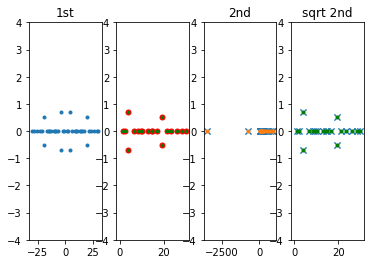

wavelength: 2.113793103448276
conditioning of AO: 2793
[1, 3, 4, 6, 8, 10, 12, 13, 14, 18, 20, 21, 22, 26, 27, 28, 29, 34, 35, 36, 41]
21
[  0.        -60.7938898j   -0.        +60.7938898j
  -0.        -28.86612308j  -0.        +28.86612308j
  30.98011888 +0.j         -30.98011888 +0.j
  29.40156794 -0.j         -29.40156794 -0.j
  26.94688581 -0.j         -26.94688581 +0.j
  24.07121616 -0.j         -24.07121616 +0.j
  22.02710687 +0.j          20.05182473 +0.5266017j
  20.05182473 -0.5266017j  -22.02710687 +0.j
 -20.05182473 +0.5266017j  -20.05182473 -0.5266017j
  17.31598344 -0.j         -17.31598344 -0.j
  15.2184098  +0.j          14.96989412 +0.j
  13.28571831 -0.j         -15.2184098  -0.j
 -14.96989412 +0.j         -13.28571831 +0.j
  10.43312495 +0.j           9.85735678 -0.j
   8.67672194 -0.j           6.67354584 -0.j
 -10.43312495 -0.j          -9.85735678 +0.j
  -8.67672194 -0.j          -6.67354584 +0.j
   4.05740921 -0.73966516j   4.05740921 +0.73966516j
   2.32121372 -

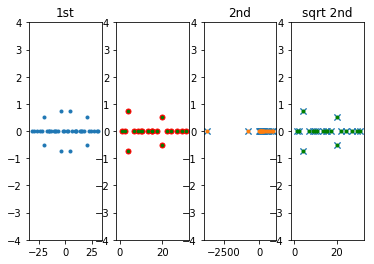

wavelength: 2.1758620689655173
conditioning of AO: 2960
[1, 3, 4, 6, 8, 10, 12, 13, 14, 18, 20, 21, 22, 26, 27, 28, 29, 34, 35, 38, 40]
21
[  0.        -62.58042633j  -0.        +62.58042633j
   0.        -29.72160238j  -0.        +29.72160238j
  31.91042135 +0.j         -31.91042135 -0.j
  30.26358816 -0.j         -30.26358816 -0.j
  27.73497039 -0.j         -27.73497039 -0.j
  24.77614448 -0.j         -24.77614448 +0.j
  22.6719655  -0.j          20.64935309 -0.53253425j
  20.64935309 +0.53253425j -22.6719655  +0.j
 -20.64935309 +0.53253425j -20.64935309 -0.53253425j
  17.82062675 -0.j         -17.82062675 +0.j
  15.66252343 -0.j          15.44148935 +0.j
  13.66803813 +0.j         -15.66252343 +0.j
 -15.44148935 -0.j         -13.66803813 +0.j
  10.70359619 +0.j          10.22096048 +0.j
   8.9265762  +0.j           6.86034336 +0.j
 -10.70359619 -0.j         -10.22096048 +0.j
  -8.9265762  -0.j          -6.86034336 -0.j
   4.22284587 -0.77246944j   4.22284587 +0.77246944j
  -4.222845

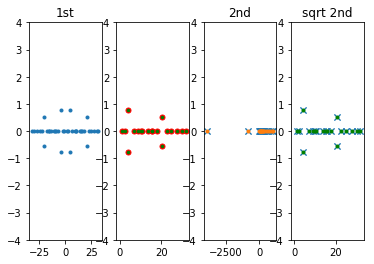

wavelength: 2.2379310344827585
conditioning of AO: 3131
[1, 3, 6, 7, 9, 11, 15, 16, 17, 19, 23, 24, 25, 28, 29, 31, 32, 34, 35, 38, 41]
21
[ -0.        -64.36692431j  -0.        +64.36692431j
  -0.        -30.57686502j   0.        +30.57686502j
 -32.84012767 +0.j         -31.12564407 -0.j
  32.84012767 +0.j          31.12564407 +0.j
 -28.52316249 -0.j          28.52316249 +0.j
 -25.48111923 +0.j          25.48111923 +0.j
 -23.31687854 -0.j         -21.24663621 -0.5383919j
 -21.24663621 +0.5383919j   23.31687854 -0.j
  21.24663621 -0.5383919j   21.24663621 +0.5383919j
 -18.3253339  +0.j          18.3253339  -0.j
 -16.1067138  +0.j         -15.9120226  +0.j
 -14.05075673 -0.j          16.1067138  +0.j
  15.9120226  -0.j          14.05075673 -0.j
 -10.96293736 +0.j         -10.5943912  -0.j
  10.96293736 -0.j          10.5943912  +0.j
  -9.17655946 +0.j           9.17655946 -0.j
   7.047515   +0.j          -7.047515   -0.j
   4.38552029 -0.8015167j    4.38552029 +0.8015167j
  -4.38552029 

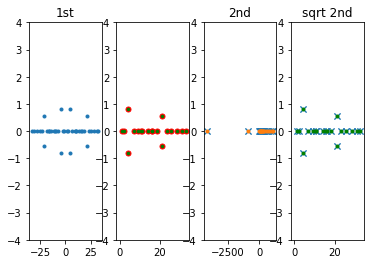

wavelength: 2.3
conditioning of AO: 3307
[1, 3, 4, 6, 8, 10, 12, 13, 14, 18, 20, 21, 22, 26, 27, 28, 29, 34, 35, 36, 40]
21
[ -0.        -66.1533869j   -0.        +66.1533869j
  -0.        -31.43192868j   0.        +31.43192868j
  33.76928893 +0.j         -33.76928893 -0.j
  31.98773279 -0.j         -31.98773279 +0.j
  29.31145151 -0.j         -29.31145151 +0.j
  26.18613699 +0.j         -26.18613699 -0.j
  23.96184146 -0.j          21.84369453 -0.5441912j
  21.84369453 +0.5441912j  -23.96184146 +0.j
 -21.84369453 -0.5441912j  -21.84369453 +0.5441912j
  18.83010149 -0.j         -18.83010149 +0.j
  16.55097451 +0.j          16.38160545 +0.j
  14.4338179  +0.j         -16.55097451 -0.j
 -16.38160545 +0.j         -14.4338179  -0.j
  11.19416815 -0.j          10.99476123 -0.j
   9.42666127 -0.j           7.23501555 -0.j
 -11.19416815 +0.j         -10.99476123 -0.j
  -9.42666127 -0.j          -7.23501555 +0.j
   4.54590396 -0.82766656j   4.54590396 +0.82766656j
   2.47351483 -0.j          -

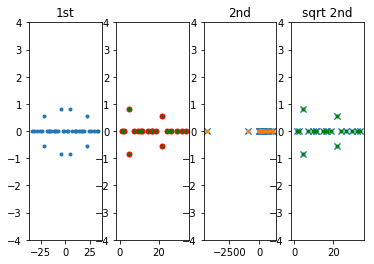

In [10]:
## IMPORTANT TO NOTE: the indices for everything beyond this points are indexed from -num_ord to num_ord+1

## alternate construction of 1D convolution matrix
zeros = np.zeros((PQ, PQ))

I = np.eye(2 * num_ord + 1)
## simulation parameters
theta = (0)*np.pi/180;
spectra = list();
spectra_T = list();

wavelength_scan = np.linspace(0.5,2.3,30)
## construct permittivity harmonic components E
#fill factor = 0 is complete dielectric, 1 is air

# E is now the convolution of fourier amplitudes
for wvlen in wavelength_scan:
    j = cmath.sqrt(-1);
    lam0 = wvlen;     k0 = 2 * np.pi / lam0; #free space wavelength in SI units
    print('wavelength: ' + str(wvlen));
    ## =====================STRUCTURE======================##

    ## Region I: reflected region (half space)
    n1 = 1;#cmath.sqrt(-1)*1e-12; #apparently small complex perturbations are bad in Region 1, these shouldn't be necessary

    ## Region 2; transmitted region
    n2 = 1;

    #from the kx_components given the indices and wvln
    kx_array = k0*(n1*np.sin(theta) + indices*(lam0 / lattice_constant)); #0 is one of them, k0*lam0 = 2*pi
    k_xi = kx_array;
    ## IMPLEMENT SCALING: these are the fourier orders of the x-direction decomposition.
    KX = np.diag((k_xi/k0)); #singular since we have a n=0, m= 0 order and incidence is normal

    ## construct matrix of Gamma^2 ('constant' term in ODE):
    B = (KX@bslash(E, KX) - I); #conditioning of this matrix is not bad, A SHOULD BE SYMMETRIC

    AO = np.block([[zeros, np.linalg.inv(E_conv_inv)],[B, zeros]])
    beigenvals, bigW = LA.eig(AO);
    print('conditioning of AO: %d'%np.linalg.cond(AO))
#     print('conditioning of big block: '+str(np.linalg.cond(AO)))
    #try rounding...
    rounded_beigenvals = np.array([round(i,10) for i in beigenvals])
    #print(rounded_beigenvals)
#     quadrant_sort = [1 if np.real(i)>=0 and np.imag(i)>=0 else 0 for i in rounded_beigenvals];
#     sorted_indices = np.nonzero(quadrant_sort)[0]
#     print(len(sorted_indices))
    sorted_eigs, sorted_indices =nonHermitianEigenSorter(rounded_beigenvals)
    print(sorted_indices)
    print(len(sorted_indices))
    sorted_eigenmodes = bigW[:,sorted_indices];
    #print(sorted_eigenmodes)
    #adding real and imaginary parts seems to work...
    sorted_eigenvals = beigenvals[sorted_indices]
    
    
    Wp = sorted_eigenmodes[0:PQ:,0:PQ]
    eigenvals_wp = (sorted_eigenvals[0:PQ]);    

    eigenvals, W = LA.eig(np.linalg.inv(E_conv_inv)@B);
    print(rounded_beigenvals)
    #print('big: '+str(eigenvals_wp))
    print(np.sqrt(eigenvals))
    W = Wp;
    #we should be gauranteed that all eigenvals are REAL
    #eigenvals = eigenvals.astype('complex');
    Q = np.diag(eigenvals_wp); #Q should only be positive square root of eigenvals
    #Q = np.diag(np.sqrt(eigenvals))
    V = E_conv_inv@(W@Q); #H modes

    plt.subplot(141)
    plt.plot(np.real(beigenvals), np.imag(beigenvals), '.'); plt.title('1st'); plt.ylim([-4,4])
    plt.subplot(142)
    plt.plot(np.real(eigenvals_wp), (np.imag(eigenvals_wp)), '.r', markersize = 10)
    plt.plot(np.real(np.sqrt(eigenvals)), (np.imag(np.sqrt(eigenvals))), '.g', markersize = 5)

    plt.ylim([-4,4])
    plt.subplot(143);
    plt.plot(np.real(beigenvals**2), np.imag(beigenvals**2), 'x');
    plt.plot(np.real(eigenvals), np.imag(eigenvals), '.'); plt.title('2nd')

    plt.ylim([-4,4])
    plt.subplot(144)
    plt.plot(np.real(np.sqrt(beigenvals**2)), np.imag(np.sqrt(beigenvals**2)), 'x');

    plt.plot(np.real(np.sqrt(eigenvals)), np.imag(np.sqrt(eigenvals)), '.g'); plt.title('sqrt 2nd')
    plt.ylim([-4,4])
    plt.show();
    
    ## this is the great typo which has killed us all this time
    X = np.diag(np.exp(-k0*np.diag(Q)*d)); #this is poorly conditioned because exponentiation
    ## pointwise exponentiation vs exponentiating a matrix

    ## observation: almost everything beyond this point is worse conditioned
    k_I = k0**2*(n1**2 - (k_xi/k0)**2);                 #k_z in reflected region k_I,zi
    k_II = k0**2*(n2**2 - (k_xi/k0)**2);   #k_z in transmitted region
    k_I = k_I.astype('complex'); k_I = np.sqrt(k_I);
    k_II = k_II.astype('complex'); k_II = np.sqrt(k_II);
    Z_I = np.diag(k_I / (n1**2 * k0 ));
    Z_II = np.diag(k_II /(n2**2 * k0));
    delta_i0 = np.zeros((len(kx_array),1));
    delta_i0[num_ord] = 1;
    n_delta_i0 = delta_i0*j*np.cos(theta)/n1;

    ## design auxiliary variables: SEE derivation in notebooks: RCWA_note.ipynb
    # we want to design the computation to avoid operating with X, particularly with inverses
    # since X is the worst conditioned thing

    O = np.block([
        [W, W],
        [V,-V]
    ]); #this is much better conditioned than S..
    f = I;
    g = j * Z_II; #all matrices
    fg = np.concatenate((f,g),axis = 0)
    ab = np.matmul(np.linalg.inv(O),fg);
    a = ab[0:PQ,:];
    b = ab[PQ:,:];

    term = X @ a @ np.linalg.inv(b) @ X;
    f = W @ (I+term);
    g = V@(-I+term);
    T = np.linalg.inv(np.matmul(j*Z_I, f) + g);
    T = np.dot(T, (np.dot(j*Z_I, delta_i0) + n_delta_i0));
    R = np.dot(f,T)-delta_i0; #shouldn't change
    T = np.dot(np.matmul(np.linalg.inv(b),X),T)

    ## calculate diffraction efficiencies
    #I would expect this number to be real...
    DE_ri = R*np.conj(R)*np.real(np.expand_dims(k_I,1))/(k0*n1*np.cos(theta));
    DE_ti = T*np.conj(T)*np.real(np.expand_dims(k_II,1)/n2**2)/(k0*np.cos(theta)/n1);

    #print(np.sum(DE_ri))
    spectra.append(np.sum(DE_ri)); #spectra_T.append(T);
    spectra_T.append(np.sum(DE_ti))




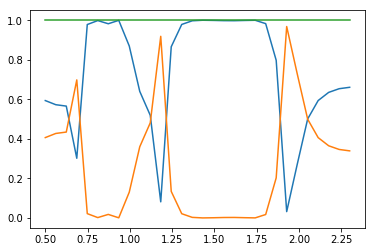

In [11]:
spectra = np.array(spectra);
spectra_T = np.array(spectra_T)
plt.figure();
plt.plot(wavelength_scan, spectra);
plt.plot(wavelength_scan, spectra_T)
plt.plot(wavelength_scan, spectra+spectra_T)
# plt.legend(['reflection', 'transmission'])
# plt.axhline(((3.48-1)/(3.48+1))**2,xmin=0, xmax = max(wavelength_scan))
# plt.axhline(((3.48-1)/(3.48+1)),xmin=0, xmax = max(wavelength_scan), color='r')
#
plt.show()


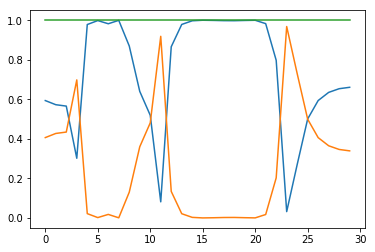

In [12]:
plt.plot(spectra)
plt.plot(spectra_T)
plt.plot(np.array(spectra)+np.array(spectra_T))
